<a href="https://colab.research.google.com/github/anaguilarar/drone_data/blob/master/cloud_points_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/anaguilarar/drone_data.git

Cloning into 'drone_data'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 90 (delta 35), reused 70 (delta 17), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [14]:
!pip install -r /content/drone_data/requirements.txt

     |████████████████████████████████| 130 kB 36.8 MB/s 


In [ ]:
import os
os.chdir('drone_data')

## Cloud Points


In this example, we are going to explore the different functions that have been developed for reading an XYZ file, aimed at constructing and visualizing 3D-RGB features. 

To use this script, first will be necessary to have at least one XYZ type file (this can be obtained from the Pix4D 3D reconstruction function) and one vector file (shp) that encompases the region of interest. For this example we will employ a file that was taken for a single chinese cabbage plant.


### Reading a single or multiple XYZ files

Here we are going to use a function named CloudPoints, this has as requirements the XYZ files path and a geopandas dataframe that contains the region of interest.



In [1]:
import geopandas as gpd
from utils.xyz_functions import CloudPoints
### read the region of interest as geopandas
roi = gpd.read_file("data/plant_frame.shp")

## here we specify the location of all the xyz files that we want to read
xyz_filenames = ["data/xyz_toyset_rgb_210922.xyz",
                 "data/xyz_toyset_rgb_210929.xyz"]

## The output will contains a list of geopandas dataframes
plant_cloudpoints = CloudPoints(xyz_filenames, roi.geometry[0])

plant_cloudpoints.cloud_points[0].head()


,0,1,2,3,4,5,geometry
90162,368138.872,3956091.753,96.274,30,28,26,POINT (368138.872 3956091.753)
90185,368138.872,3956091.845,96.301,15,14,16,POINT (368138.872 3956091.845)
90216,368138.872,3956091.775,96.272,8,7,8,POINT (368138.872 3956091.775)
90298,368138.872,3956092.046,96.366,30,28,28,POINT (368138.872 3956092.046)
90500,368138.872,3956091.668,96.267,60,53,49,POINT (368138.872 3956091.668)


### 2D Visualizations

Once the data was read, we can create different plots. Here we will create a graphic to visualize our plant (Chinese cabbage) in a 2D graphic either plotting the plant from its front or its side. 

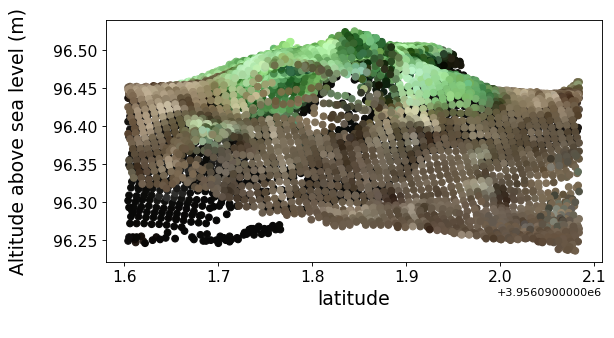

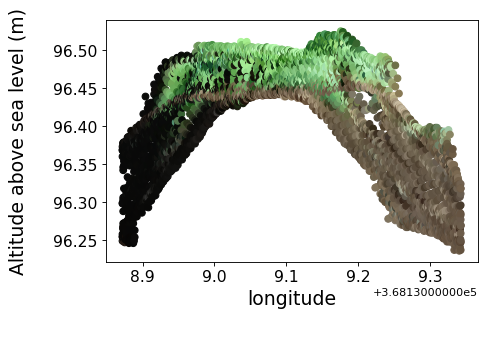

In [2]:
plant_cloudpoints.plot_2d_cloudpoints(index = 1, figsize= (8,4), fontsize = 14)
plant_cloudpoints.plot_2d_cloudpoints(index = 1, xaxis = "longitude", figsize= (6,4), fontsize = 14)

### Rasterize data

Now we have the data as a data frame, but we can transform this data into a raster image. This will help not only to save memory space but also will allow stacking multiple dates. The output will be a raster in which is values are the altitude, besides the file will be a xarray instance of three dimensions (date, x, and y).
For rasterization, we have implemented three different methods, one is using the rasterio rasterize function, which assigns a DN value to a mesh grid, the second and third are spatial interpolations, K-nearest neighbors, and ordinary-kriging.

Text(0.5, 1.0, 'ordinary_kriging')

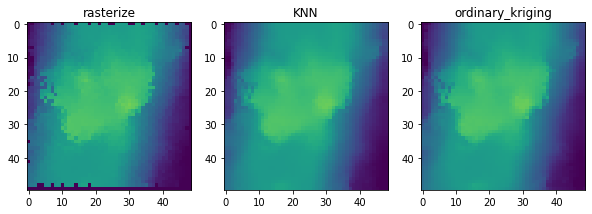

In [3]:
import matplotlib.pyplot as plt

rasterize = plant_cloudpoints.to_xarray(sp_res = 0.01, ## this will be spatial resolution in meters
                                           )
raster_intknn = plant_cloudpoints.to_xarray(sp_res = 0.01, ## this would be spatial resolution in meters
                                            interpolate = True,## activates the interpolation function
                                            inter_method = 'KNN' ## which is going to be the interpolation method
                                            )

## this method will take longer than the previos ones                                         
raster_intkriging = plant_cloudpoints.to_xarray(sp_res = 0.01, ## this will be spatial resolution in meters
                                              interpolate = True, ## activates the interpolation function
                                             inter_method = 'ordinary_kriging', ## which is going to be the interpolation method
                                             variogram_model = 'exponential')

## plots
f, a = plt.subplots(nrows = 1, ncols = 3, figsize = (10,5))
a[0].imshow(rasterize.z.isel(date = 1), vmin = 96.25, vmax = 96.6)
a[0].set_title('rasterize')
a[1].imshow(raster_intknn.z.isel(date = 1), vmin = 96.25, vmax = 96.6)
a[1].set_title('KNN')
a[2].imshow(raster_intkriging.z.isel(date = 1), vmin = 96.25, vmax = 96.6)
a[2].set_title('ordinary_kriging')

Likewise, we can get a multitemporal vizualisation

(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'210922'}>,
        <AxesSubplot:title={'center':'210929'}>], dtype=object))

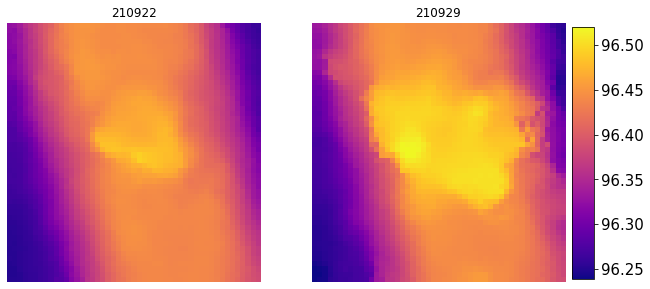

In [4]:
from utils.plt_functions import plot_multichanels

heightdata = raster_intknn.z.isel(date=slice(0, 2)).copy()

plot_multichanels(heightdata.values,num_rows=1,num_columns = 2,
                  chanels_names=["210922","210929"],figsize=(10,5), cmap= 'plasma')


Or a 3D plot visualization

In [5]:
### 3D plot
%matplotlib inline
from utils.plt_functions import plot_3d_cloudpoints

plot_3d_cloudpoints(raster_intknn.isel(date = 1).copy(),scale_xy=1)

Or to plot a the plant height across the time given a ground reference

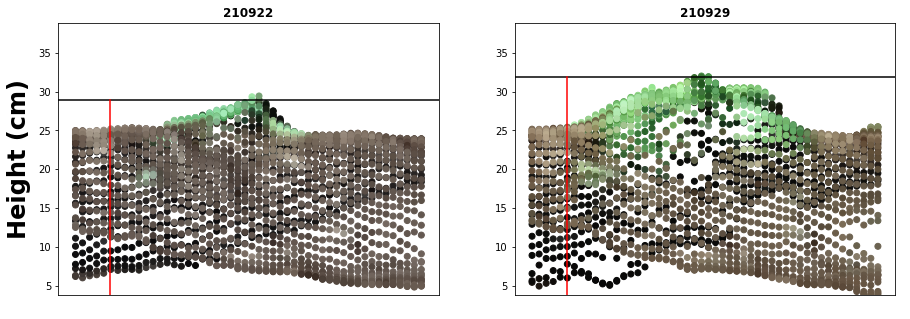

In [6]:
from utils.plt_functions import plot_heights

f,a = plot_heights(raster_intknn,1,2, chanels_names = ["210922","210929"], 
             figsize=(15,5), phquantile = 0.999, bsl = 96.2 )

### Calculate image at

Aimed at providing different kinds of metrics that can characterize the plant, we have added a function that can calculate the leaf angle. this angle will be calculated using a perpendicular vector located in image center.


(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'210922'}>,
        <AxesSubplot:title={'center':'210929'}>], dtype=object))

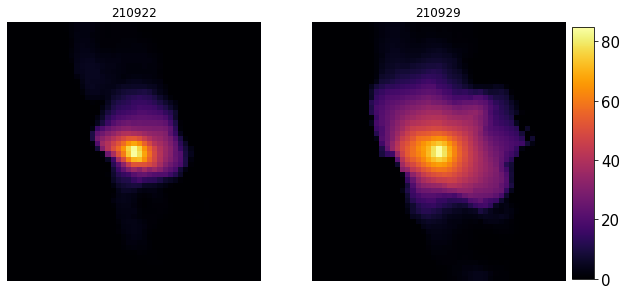

In [7]:
from utils.xyz_functions import get_baseline_altitude, calculate_leaf_angle

### this is to find a ground reference
imgalt = get_baseline_altitude(plant_cloudpoints.cloud_points[0])
raster_intknn['z'] = (raster_intknn['z'] - imgalt)*100
raster_intknn = raster_intknn.where(raster_intknn.z.values>0, 0)

xrtestfilledleaf_angle = calculate_leaf_angle(raster_intknn, invert=True)


plot_multichanels(xrtestfilledleaf_angle.leaf_angle.values,num_rows=1,num_columns = 2,
                  chanels_names=["210922","210929"],figsize=(10,5), cmap= 'inferno')


Likewise, it is possible to calculate terrain metrics using auxiliary package

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


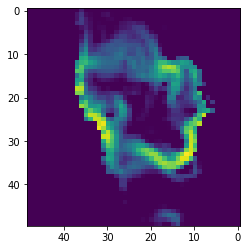

In [11]:
from utils.xr_functions import calculate_terrain_layers
dataslope = calculate_terrain_layers(raster_intknn.copy(), attrib= 'slope_degrees')

plt.imshow(dataslope.slope_degrees.isel(date = 1),vmin = 10)
plt.gca().invert_xaxis()
